In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import LabelEncoder

In [7]:
import os

def open_files_in_dir(path):
    files = {}
    with os.scandir(path) as entries:
        for entry in entries:
            if entry.is_file():
                files[entry.name.split('.')[0]] = pd.read_csv(entry)
    return files

basepath = 'C:/datasets/sales/'
files_sales = open_files_in_dir(basepath)
print(files_sales.keys())

dict_keys(['items', 'item_categories', 'sales_train', 'sample_submission', 'shops', 'test'])


In [8]:
files_sales['sales_train']

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


## DQC class

At first, we can create class which will encapsulate some information about given files.

In [9]:
class DQC:
    
    def __init__(this, our_files):
        this.files = our_files
    
    def print_head(this, table_name):
        print(this.files[table_name].head())
        
    def are_there_any_duplicates(this):
        
        sum_of_dupl = 0
        tables = []
        for file in this.files:
            if this.files[file].duplicated().sum()!=0:
                tables.append(file)
                sum_of_dupl += this.files[file].duplicated().sum()
                
            else: sum_of_dupl += this.files[file].duplicated().sum()
                
        return f"The amount of duplicated data in all the tables: {sum_of_dupl}; Tables with duplicates: {tables}"
    
    def are_there_any_null_values(this):
        
        info = []
        
        for file in this.files:
            info.append(f"Table {file} contains {this.files[file].isna().sum().sum()} empty raws")
            
        return info
    
    def are_there_any_outliers(this):
                
        fig, ax = plt.subplots(1, 2, figsize=(10, 6))
        # add padding between the subplots
        plt.subplots_adjust(wspace=0.5) 

        # draw boxplot for age in the 1st subplot
        sns.boxplot(data=this.files['sales_train']['item_price'], ax=ax[0],)
        ax[0].set_xlabel('item_price')
        
        sns.boxplot(data=this.files['sales_train']['item_cnt_day'], ax=ax[1],)
        ax[1].set_xlabel('item_cnt_day')
        
    def columns_type_and_structure(this):
        
        for file in this.files:
            print(f'Table "{file}" with {this.files[file].shape[0]} values:')
            print(this.files[file].dtypes)
            print('\n')
            
    def are_there_any_negative_values(this):
        
        temp_table = this.files['sales_train']
        for col in temp_table.columns:
            if temp_table[col].dtype != "O":
                negs =  len(temp_table[temp_table[col]<0])
                print(f"The precent of negative values in sales_train table in {col} column: {round(negs*100/len(temp_table),5)}")
                if negs!=0: 
                    print('\n')
                    print(temp_table[temp_table[col]<0].head())
                    print('\n')
                    
    def the_returned(this):
        
        sales_train = this.files['sales_train']
        returned = sales_train[sales_train['item_cnt_day']<=0]
        
        return returned
    
    def is_actually_a_return(this):
        
        returned = this.the_returned()
        colors = sns.color_palette('pastel')[0:5]
        
        plt.figure()
        plt.title('Item ids:')
        plt.pie(returned['item_id'].value_counts().head(), labels = returned['item_id'].value_counts().head().index, colors = colors)
        
        plt.figure()
        plt.title('Shop ids:')
        plt.pie(returned['shop_id'].value_counts().head(), labels = returned['shop_id'].value_counts().head().index, colors = colors)
        
        dif_date = returned['date'].nunique()
        print('Amount of unique dates:',dif_date)
        
    def consistancy_info(this):
        
        test_shop_ids = this.files['test']["shop_id"].unique()
        test_item_ids = this.files['test']["item_id"].unique()
        
        print("Data set size total:", this.files['sales_train'].shape[0])

        # Only shops that exist in test set.
        train = this.files['sales_train'][this.files['sales_train']["shop_id"].isin(test_shop_ids)]
        # Only items that exist in test set.
        train = train[train["item_id"].isin(test_item_ids)]

        print("Data set size leaking in test", train.shape[0])
    
    
    def sales_per_time_visualisation(this):
        pass


## DQC methods

In [10]:
dqc = DQC(files_sales)

In [11]:
dqc.columns_type_and_structure()

Table "items" with 22170 values:
item_name           object
item_id              int64
item_category_id     int64
dtype: object


Table "item_categories" with 84 values:
item_category_name    object
item_category_id       int64
dtype: object


Table "sales_train" with 2935849 values:
date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object


Table "sample_submission" with 214200 values:
ID                  int64
item_cnt_month    float64
dtype: object


Table "shops" with 60 values:
shop_name    object
shop_id       int64
dtype: object


Table "test" with 214200 values:
ID         int64
shop_id    int64
item_id    int64
dtype: object




6 tables, 2 of them contain test values.

There are 2935849 values in train set and 214200 in test set (about 14:1).

In test values we have amount of sold items in a month while in training set we use daily measure. Date is an object, can be converted in datetime type, then we also can lessen periods of time from date to look at some dynamics.

In [12]:
dqc.consistancy_info()

Data set size total: 2935849
Data set size leaking in test 1224439


In test set we have shops and items that will be unfamiliar to the future model since there is no such shops in items in the training set.

In [13]:
dqc.print_head('sales_train')

         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0


From first 5 rows we already see that there are returns (neg item_cnt_day). We can look at it closely.

In [14]:
dqc.are_there_any_negative_values()

The precent of negative values in sales_train table in date_block_num column: 0.0
The precent of negative values in sales_train table in shop_id column: 0.0
The precent of negative values in sales_train table in item_id column: 0.0
The precent of negative values in sales_train table in item_price column: 3e-05


              date  date_block_num  shop_id  item_id  item_price  item_cnt_day
484683  15.05.2013               4       32     2973        -1.0           1.0


The precent of negative values in sales_train table in item_cnt_day column: 0.25056


            date  date_block_num  shop_id  item_id  item_price  item_cnt_day
2     05.01.2013               0       25     2552       899.0          -1.0
148   23.01.2013               0       25     2321       999.0          -1.0
175   07.01.2013               0       25     2199      1449.0          -1.0
807   02.01.2013               0       25     2330       599.0          -1.0
1041  13.01.2013               0       25     5034     

Negative values can be deleted.

Amount of unique dates: 1023


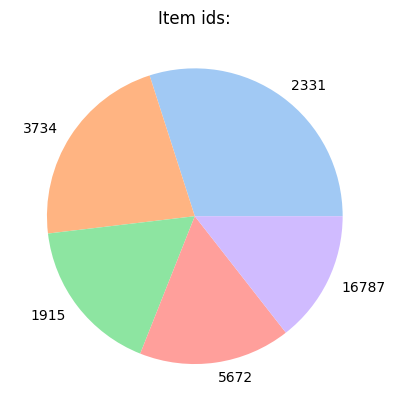

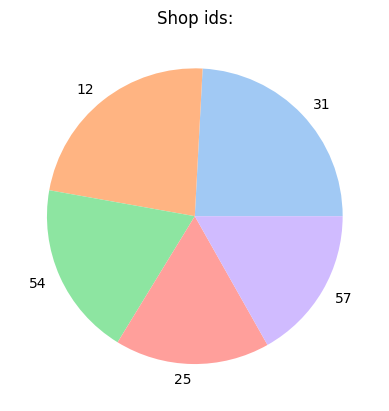

In [15]:
dqc.is_actually_a_return()

Returns happen with a lot of different type of items in a lot of different shops. The dates are also pretty diverse.

In [16]:
dqc.are_there_any_null_values()

['Table items contains 0 empty raws',
 'Table item_categories contains 0 empty raws',
 'Table sales_train contains 0 empty raws',
 'Table sample_submission contains 0 empty raws',
 'Table shops contains 0 empty raws',
 'Table test contains 0 empty raws']

No missing data.

In [17]:
dqc.are_there_any_duplicates()

"The amount of duplicated data in all the tables: 6; Tables with duplicates: ['sales_train']"

Found some duplicated rows. Only 6, so it can be safely deleted or ignored.

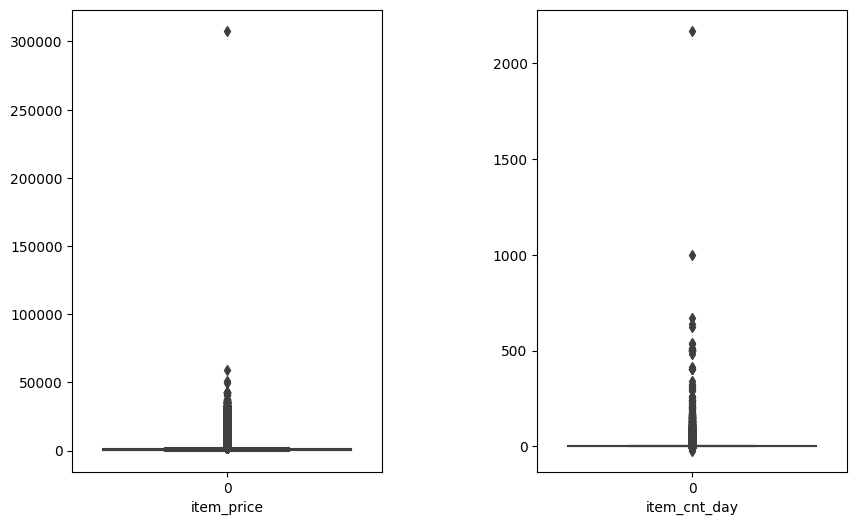

In [18]:
dqc.are_there_any_outliers()

Explicit outliers in item_price and item_cnt_day. We can look at them closely.

In [19]:
files_sales['sales_train'][files_sales['sales_train']['item_price']>=300000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,13.12.2013,11,12,6066,307980.0,1.0


In [20]:
files_sales['sales_train'][files_sales['sales_train']['item_cnt_day']>=800]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2326930,15.01.2015,24,12,20949,4.000000,1000.0
2909818,28.10.2015,33,12,11373,0.908714,2169.0


In [21]:
files_sales['shops'][files_sales['shops']['shop_id']==12]

,shop_name,shop_id
12,Интернет-магазин ЧС,12


In [22]:
files_sales['items'][(files_sales['items']['item_id']==11373)|(files_sales['items']['item_id']==20949)|(files_sales['items']['item_id']==6066)]

,item_name,item_id,item_category_id
6066,Radmin 3 - 522 лиц.,6066,75
11373,Доставка до пункта выдачи (Boxberry),11373,9
20949,Фирменный пакет майка 1С Интерес белый (34*42)...,20949,71


522 licenses in the set explains the standout price of the item. The same can be said about the amount of sold items per day: regular packing bags and delivery service.

We also see that people tend to buy things in greater numbers through online stores.

These values can be removed.

### Merging

In [23]:
train = pd.merge(files_sales['sales_train'], files_sales['shops'], on='shop_id', how = 'left')
train = pd.merge(train, files_sales['items'], on='item_id', how = 'left')
train = pd.merge(train, files_sales['item_categories'], on='item_category_id', how = 'left')
        
test = pd.merge(files_sales['test'], files_sales['shops'], on='shop_id', how = 'left')
test = pd.merge(test, files_sales['items'], on='item_id', how = 'left')
test = pd.merge(test, files_sales['item_categories'], on='item_category_id', how = 'left')
test.insert(loc=0,column='date_block_num',value=train['date_block_num'].max()+1)

### Categorial feathures

In [24]:
train['shop_name'].value_counts().head(20)

Москва ТЦ "Семеновский"            235636
Москва ТРК "Атриум"                186104
Химки ТЦ "Мега"                    143480
Москва ТЦ "МЕГА Теплый Стан" II    142234
Якутск Орджоникидзе, 56            117428
СПб ТК "Невский Центр"             109253
Москва ТЦ "МЕГА Белая Дача II"     105366
Воронеж (Плехановская, 13)          82663
Якутск ТЦ "Центральный"             71441
Чехов ТРЦ "Карнавал"                69573
Сергиев Посад ТЦ "7Я"               66321
Тюмень ТЦ "Гудвин"                  65173
Курск ТЦ "Пушкинский"               63911
Калуга ТРЦ "XXI век"                59511
Н.Новгород ТРЦ "Фантастика"         58445
Москва МТРЦ "Афи Молл"              58133
Воронеж ТРЦ "Максимир"              58076
Сургут ТРЦ "Сити Молл"              56695
Москва ТЦ "Ареал" (Беляево)         53910
Красноярск ТЦ "Июнь"                53227
Name: shop_name, dtype: int64

As we can see names have a pattern: location - type - shop name. We can extract some information here, maybe it will be useful.

In [25]:
train['location'] = train['shop_name'].str.split(" ").str[0]
train['shop_type'] = train['shop_name'].str.split(" ").str[1]

In [26]:
test['location'] = test['shop_name'].str.split(" ").str[0]
test['shop_type'] = test['shop_name'].str.split(" ").str[1]

In [27]:
train['location'].value_counts()
train['shop_type'].value_counts()

ТЦ                1585309
ТРЦ                387410
ТК                 252032
ТРК                234360
Орджоникидзе,      127285
(Плехановская,      82663
Посад               66321
МТРЦ                58133
Магазин             45434
склад               34769
ЧС                  34694
ул.                 21896
Торговля             3751
"Распродажа"         1792
Name: shop_type, dtype: int64

In [28]:
train.loc[train['location']=='Цифровой','location'] = 'Цифровой склад'
train.loc[train['location']=='Сергиев','location'] = 'Сергиев посад'
train.loc[train['location']=='!Якутск','location'] = 'Якутск'
train.loc[train['shop_type']=='Орджоникидзе,','shop_type'] = 'Не указан'
train.loc[train['shop_type']=='Посад','shop_type'] = 'ТЦ'
train.loc[train['shop_type']=='"Распродажа"','shop_type'] = 'Не указан'
train.loc[train['shop_type']=='(Плехановская,','shop_type'] = 'Не указан'
train.loc[train['shop_type']=='склад','shop_type'] = 'Не указан'
train.loc[train['shop_type']=='ул.','shop_type'] = 'Не указан'
train.loc[train['shop_type']=='МТРЦ','shop_type'] = 'ТРЦ'
train.loc[train['shop_type']=='Торговля','shop_type'] = 'Не указан'

In [29]:
test.loc[test['location']=='Цифровой','location'] = 'Цифровой склад'
test.loc[test['location']=='Сергиев','location'] = 'Сергиев посад'
test.loc[test['location']=='!Якутск','location'] = 'Якутск'
test.loc[test['shop_type']=='Орджоникидзе,','shop_type'] = 'Не указан'
test.loc[test['shop_type']=='Посад','shop_type'] = 'ТЦ'
test.loc[test['shop_type']=='"Распродажа"','shop_type'] = 'Не указан'
test.loc[test['shop_type']=='(Плехановская,','shop_type'] = 'Не указан'
test.loc[test['shop_type']=='склад','shop_type'] = 'Не указан'
test.loc[test['shop_type']=='ул.','shop_type'] = 'Не указан'
test.loc[test['shop_type']=='МТРЦ','shop_type'] = 'ТРЦ'
test.loc[test['shop_type']=='Торговля','shop_type'] = 'Не указан'

In the names we also can see some random symbols, "!" for example.

In [30]:
train[train['shop_name'].str.contains('Якутск')==True]['shop_name'].unique()

array(['!Якутск Орджоникидзе, 56 фран', '!Якутск ТЦ "Центральный" фран',
       'Якутск Орджоникидзе, 56', 'Якутск ТЦ "Центральный"'], dtype=object)

In [31]:
train['shop_name'].unique()

array(['Ярославль ТЦ "Альтаир"', 'Москва ТРК "Атриум"',
       'Москва ТК "Буденовский" (пав.К7)',
       'Москва ТК "Буденовский" (пав.А2)', 'Курск ТЦ "Пушкинский"',
       'Москва Магазин С21', 'Красноярск ТЦ "Июнь"',
       'Москва МТРЦ "Афи Молл"', 'Москва ТЦ "МЕГА Теплый Стан" II',
       'Москва ТЦ "МЕГА Белая Дача II"',
       'Москва ТЦ "Новый век" (Новокосино)',
       'Москва ТЦ "Ареал" (Беляево)', 'Волжский ТЦ "Волга Молл"',
       'Воронеж (Плехановская, 13)', 'Адыгея ТЦ "Мега"',
       'Балашиха ТРК "Октябрь-Киномир"', 'Воронеж ТРЦ "Максимир"',
       '!Якутск Орджоникидзе, 56 фран', '!Якутск ТЦ "Центральный" фран',
       'Коломна ТЦ "Рио"', 'Калуга ТРЦ "XXI век"',
       'Воронеж ТРЦ Сити-Парк "Град"', 'Жуковский ул. Чкалова 39м?',
       'Казань ТЦ "ПаркХаус" II', 'Казань ТЦ "Бехетле"',
       'Интернет-магазин ЧС', 'Уфа ТЦ "Семья" 2',
       'Москва ТЦ "Семеновский"', 'Москва ТЦ "Перловский"',
       'Москва ТЦ "Серебряный Дом"', 'Н.Новгород ТРЦ "Фантастика"',
       '

Some info is duplicated. The data was loaded not in the right way.

There are not that much places, so in etl we can change some things.

In [32]:
train['item_category'] = train['item_category_name'].str.split(" - ").str[0]

In [33]:
test['item_category'] = test['item_category_name'].str.split(" - ").str[0]
test["subcat"] = test["item_category_name"].str.split(" - ").map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())

In [34]:
train["subcat"] = train["item_category_name"].str.split(" - ").map(
    lambda x: x[1].strip() if len(x) > 1 else x[0].strip()
)

In [35]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name,location,shop_type,item_category,subcat
0,02.01.2013,0,59,22154,999.00,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,Ярославль,ТЦ,Кино,Blu-Ray
1,03.01.2013,0,25,2552,899.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,Москва,ТРК,Музыка,Винил
2,05.01.2013,0,25,2552,899.00,-1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,Москва,ТРК,Музыка,Винил
3,06.01.2013,0,25,2554,1709.05,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,Москва,ТРК,Музыка,Винил
4,15.01.2013,0,25,2555,1099.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,Москва,ТРК,Музыка,CD фирменного производства


Later categorical values should be changed to numerical.

## ETL

In [36]:
import sys
module_path = "C:\\github\\\internship"
if module_path not in sys.path:
    sys.path.append(module_path)
    
import ETL_sales as etl

In [4]:
''''
def length(data):
        
    data_len = data.shape[0]
        
    print(f"The amount of rows in data set: {data_len}")
    print('The amount of null values in train:',data.isna().sum().sum())
        
def delete_neg_in_price_and_sales(data):
        
    data = data[data['item_price']>0]
    data = data[data['item_cnt_day']>0]
        
    return data
    
def delete_duplicates(data):
        
    return data.drop_duplicates()
    
def remove_outliers(data, col): ##

    Q1 = data[col].quantile(0.10)
    Q3 = data[col].quantile(0.90)
    IQR = Q3 - Q1
    data = data[~((data[col] < (Q1 - 1.5 * IQR)) | (data[col] > (Q3 + 1.5 * IQR)))]
        
    return data
    
def date_format(data, col):
        
    data[col] = pd.to_datetime(data[col], format='%d.%m.%Y')
        
    data['year'] = data[col].dt.year
    data['month'] = data[col].dt.month
    data['day'] = data[col].dt.day
        
    return data
        
def to_file(data):
    
    data.to_csv(f'C:/datasets/sales/{data}_sls.csv')  
    
    ###Only after date converting
    ## через get_dummies слишком большие размерности выходят, какой-то другой метод брать или оставлять пока?
def cat_to_num(data, col):
    cat = [col for col in data.columns if data[col].dtype=='O']
    data
    return pd.get_dummies(data, columns = col)
''''

In [37]:
train = etl.delete_neg_in_price_and_sales(train)
train = etl.date_format(train, 'date')
train['year-month'] = train['date'].dt.to_period('M')
train = train[train['item_price']<300000]
train = train[train['item_cnt_day']<800]
train = etl.delete_duplicates(train)
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name,location,shop_type,item_category,subcat,year,month,day,year-month
0,2013-01-02,0,59,22154,999.00,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,Ярославль,ТЦ,Кино,Blu-Ray,2013,1,2,2013-01
1,2013-01-03,0,25,2552,899.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,Москва,ТРК,Музыка,Винил,2013,1,3,2013-01
3,2013-01-06,0,25,2554,1709.05,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,Москва,ТРК,Музыка,Винил,2013,1,6,2013-01
4,2013-01-15,0,25,2555,1099.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,Москва,ТРК,Музыка,CD фирменного производства,2013,1,15,2013-01
5,2013-01-10,0,25,2564,349.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,Музыка - Музыкальное видео,Москва,ТРК,Музыка,Музыкальное видео,2013,1,10,2013-01


In [38]:
train['shop_name'].unique()

array(['Ярославль ТЦ "Альтаир"', 'Москва ТРК "Атриум"',
       'Москва ТК "Буденовский" (пав.К7)',
       'Москва ТК "Буденовский" (пав.А2)', 'Курск ТЦ "Пушкинский"',
       'Москва Магазин С21', 'Красноярск ТЦ "Июнь"',
       'Москва МТРЦ "Афи Молл"', 'Москва ТЦ "МЕГА Теплый Стан" II',
       'Москва ТЦ "МЕГА Белая Дача II"',
       'Москва ТЦ "Новый век" (Новокосино)',
       'Москва ТЦ "Ареал" (Беляево)', 'Волжский ТЦ "Волга Молл"',
       'Воронеж (Плехановская, 13)', 'Адыгея ТЦ "Мега"',
       'Балашиха ТРК "Октябрь-Киномир"', 'Воронеж ТРЦ "Максимир"',
       '!Якутск Орджоникидзе, 56 фран', '!Якутск ТЦ "Центральный" фран',
       'Коломна ТЦ "Рио"', 'Калуга ТРЦ "XXI век"',
       'Воронеж ТРЦ Сити-Парк "Град"', 'Жуковский ул. Чкалова 39м?',
       'Казань ТЦ "ПаркХаус" II', 'Казань ТЦ "Бехетле"',
       'Интернет-магазин ЧС', 'Уфа ТЦ "Семья" 2',
       'Москва ТЦ "Семеновский"', 'Москва ТЦ "Перловский"',
       'Москва ТЦ "Серебряный Дом"', 'Н.Новгород ТРЦ "Фантастика"',
       '

In [39]:
train.loc[train['shop_name']=='!Якутск Орджоникидзе, 56 фран','shop_name'] = 'Якутск Орджоникидзе, 56'
train.loc[train['shop_name']=='!Якутск ТЦ "Центральный" фран','shop_name'] = 'Якутск ТЦ "Центральный"'
train.loc[train['shop_name']=='Москва ТК "Буденовский" (пав.К7)','shop_name'] = 'Москва ТК "Буденовский"'
train.loc[train['shop_name']=='Москва ТК "Буденовский" (пав.А2)','shop_name'] = 'Москва ТК "Буденовский"'

In [40]:
test.loc[test['shop_name']=='!Якутск Орджоникидзе, 56 фран','shop_name'] = 'Якутск Орджоникидзе, 56'
test.loc[test['shop_name']=='!Якутск ТЦ "Центральный" фран','shop_name'] = 'Якутск ТЦ "Центральный"'
test.loc[test['shop_name']=='Москва ТК "Буденовский" (пав.К7)','shop_name'] = 'Москва ТК "Буденовский"'
test.loc[test['shop_name']=='Москва ТК "Буденовский" (пав.А2)','shop_name'] = 'Москва ТК "Буденовский"'

## EDA

We should have answers to the following questions:
- What I'm working with ?
- What are the main patterns and tendencies with my data ?
- How do my data entities interact ?
- What should I do with my data to obtain good features ?
- What are the problems with the probable prediction ?
- How could I manually make predict based on data ? 

In [41]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,2928483.0,14.569756,9.422952,0.00,7.0,14.0,23.0,33.0
shop_id,2928483.0,33.002959,16.225426,0.00,22.0,31.0,47.0,59.0
item_id,2928483.0,10200.281275,6324.390884,0.00,4477.0,9355.0,15691.0,22169.0
item_price,2928483.0,889.362730,1718.155164,0.07,249.0,399.0,999.0,59200.0
item_cnt_day,2928483.0,1.247257,2.217429,1.00,1.0,1.0,1.0,669.0
item_category_id,2928483.0,40.016374,17.098094,0.00,28.0,40.0,55.0,83.0
year,2928483.0,2013.776779,0.768460,2013.00,2013.0,2014.0,2014.0,2015.0
month,2928483.0,6.248408,3.535921,1.00,3.0,6.0,9.0,12.0
day,2928483.0,15.854095,8.923421,1.00,8.0,16.0,24.0,31.0


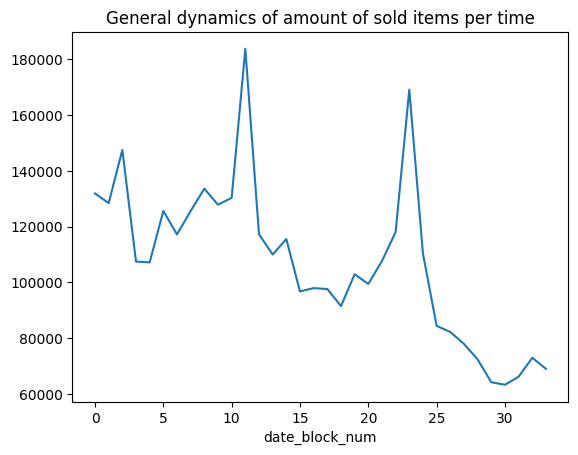

In [42]:
#general dynamics
plt.title('General dynamics of amount of sold items per time')
time_series=train.groupby(["date_block_num"])["item_cnt_day"].sum()
time_series.plot();

[]

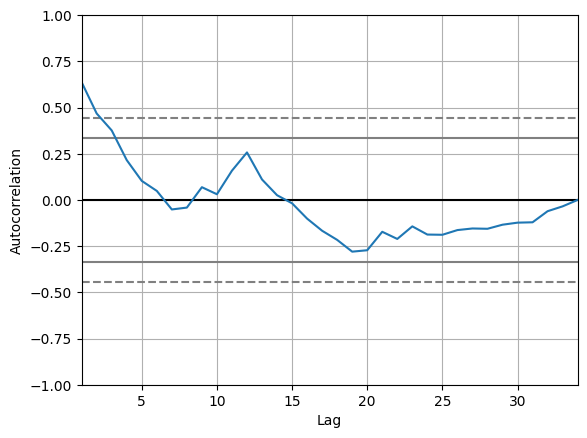

In [43]:
x = pd.plotting.autocorrelation_plot(time_series)
 
# plotting the Curve
x.plot()

We clearly see that the series is not stationary. It has a downtrend and apparently some seasonality, around a year. Both should be removed.

C:\Users\jackd\AppData\Local\Temp\ipykernel_10512\1149706082.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  date_org = train.groupby(["year-month","shop_name"])\


<AxesSubplot: xlabel='item_cnt_month', ylabel='year-month'>

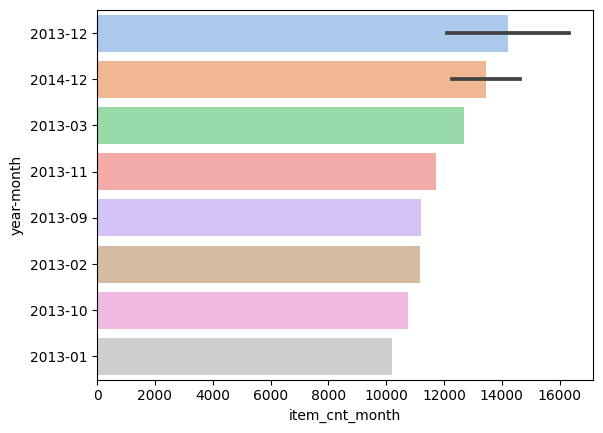

In [44]:
date_org = train.groupby(["year-month","shop_name"])\
    ["date","item_cnt_day"].agg({"item_cnt_day":"sum"}).reset_index()
date_org.columns = ['year-month','shop_name','item_cnt_month']
top = date_org.sort_values(by='item_cnt_month', ascending=False).head(10)
sns.barplot(data=top, x="item_cnt_month", y="year-month", palette='pastel')

More often people were buying in 2013, probably due to lower prices. There is also a pattern: in winter, at the end and at the beginning of the year, sales are usually higher.

In [45]:
train.groupby(['shop_name','year','month']).agg({'item_cnt_day': 'sum',})

item_cnt_day
shop_name              year month              
Адыгея ТЦ "Мега"       2013 1            1151.0
                            2             489.0
                            3             756.0
                            4             585.0
                            5             553.0
...                                         ...
Ярославль ТЦ "Альтаир" 2015 6             913.0
                            7             998.0
                            8            1216.0
                            9             915.0
                            10            792.0

[1578 rows x 1 columns]

In [46]:
helpme = train.groupby(['shop_name','year','month']).agg({'item_cnt_day': 'sum',}).reset_index()
helpme = helpme.groupby(['shop_name','year']).agg({'month': 'count',}).reset_index()
a = helpme['shop_name'].nunique()
b = helpme[((helpme['month']!=12) & (helpme['year']!=2015))|((helpme['month']<10) & (helpme['year']==2015))]['shop_name'].nunique()
print(f'The amount of shops:{a} and the amount of shops without some months:{b}')

The amount of shops:57 and the amount of shops without some months:23


For some stores there are not all months and not all years.  If this is an old data, there is a good chance that some of the stores have been simply closed. 

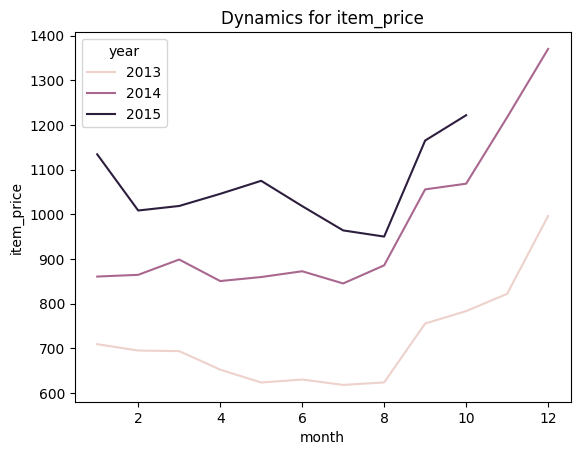

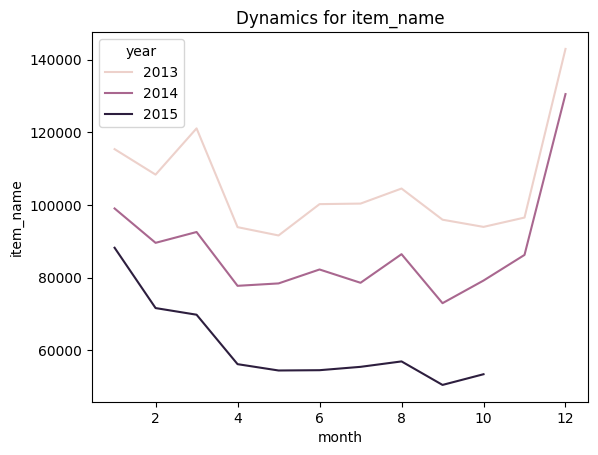

In [47]:
train_eda = train.groupby(['year','month']).agg({'item_price': 'mean','item_name': 'count',}).reset_index()
for idx, col in enumerate(train_eda.columns[2:]):
    plt.figure()
    sns.lineplot(data=train_eda, x='month', y=col, hue='year').set_title(f"Dynamics for {col}")

As expected, prices per item in 2015 is way higher than the were 1-2 years ago. For some reason every august the also tend to get bigger. We have reverse situation in amount of sold items. 

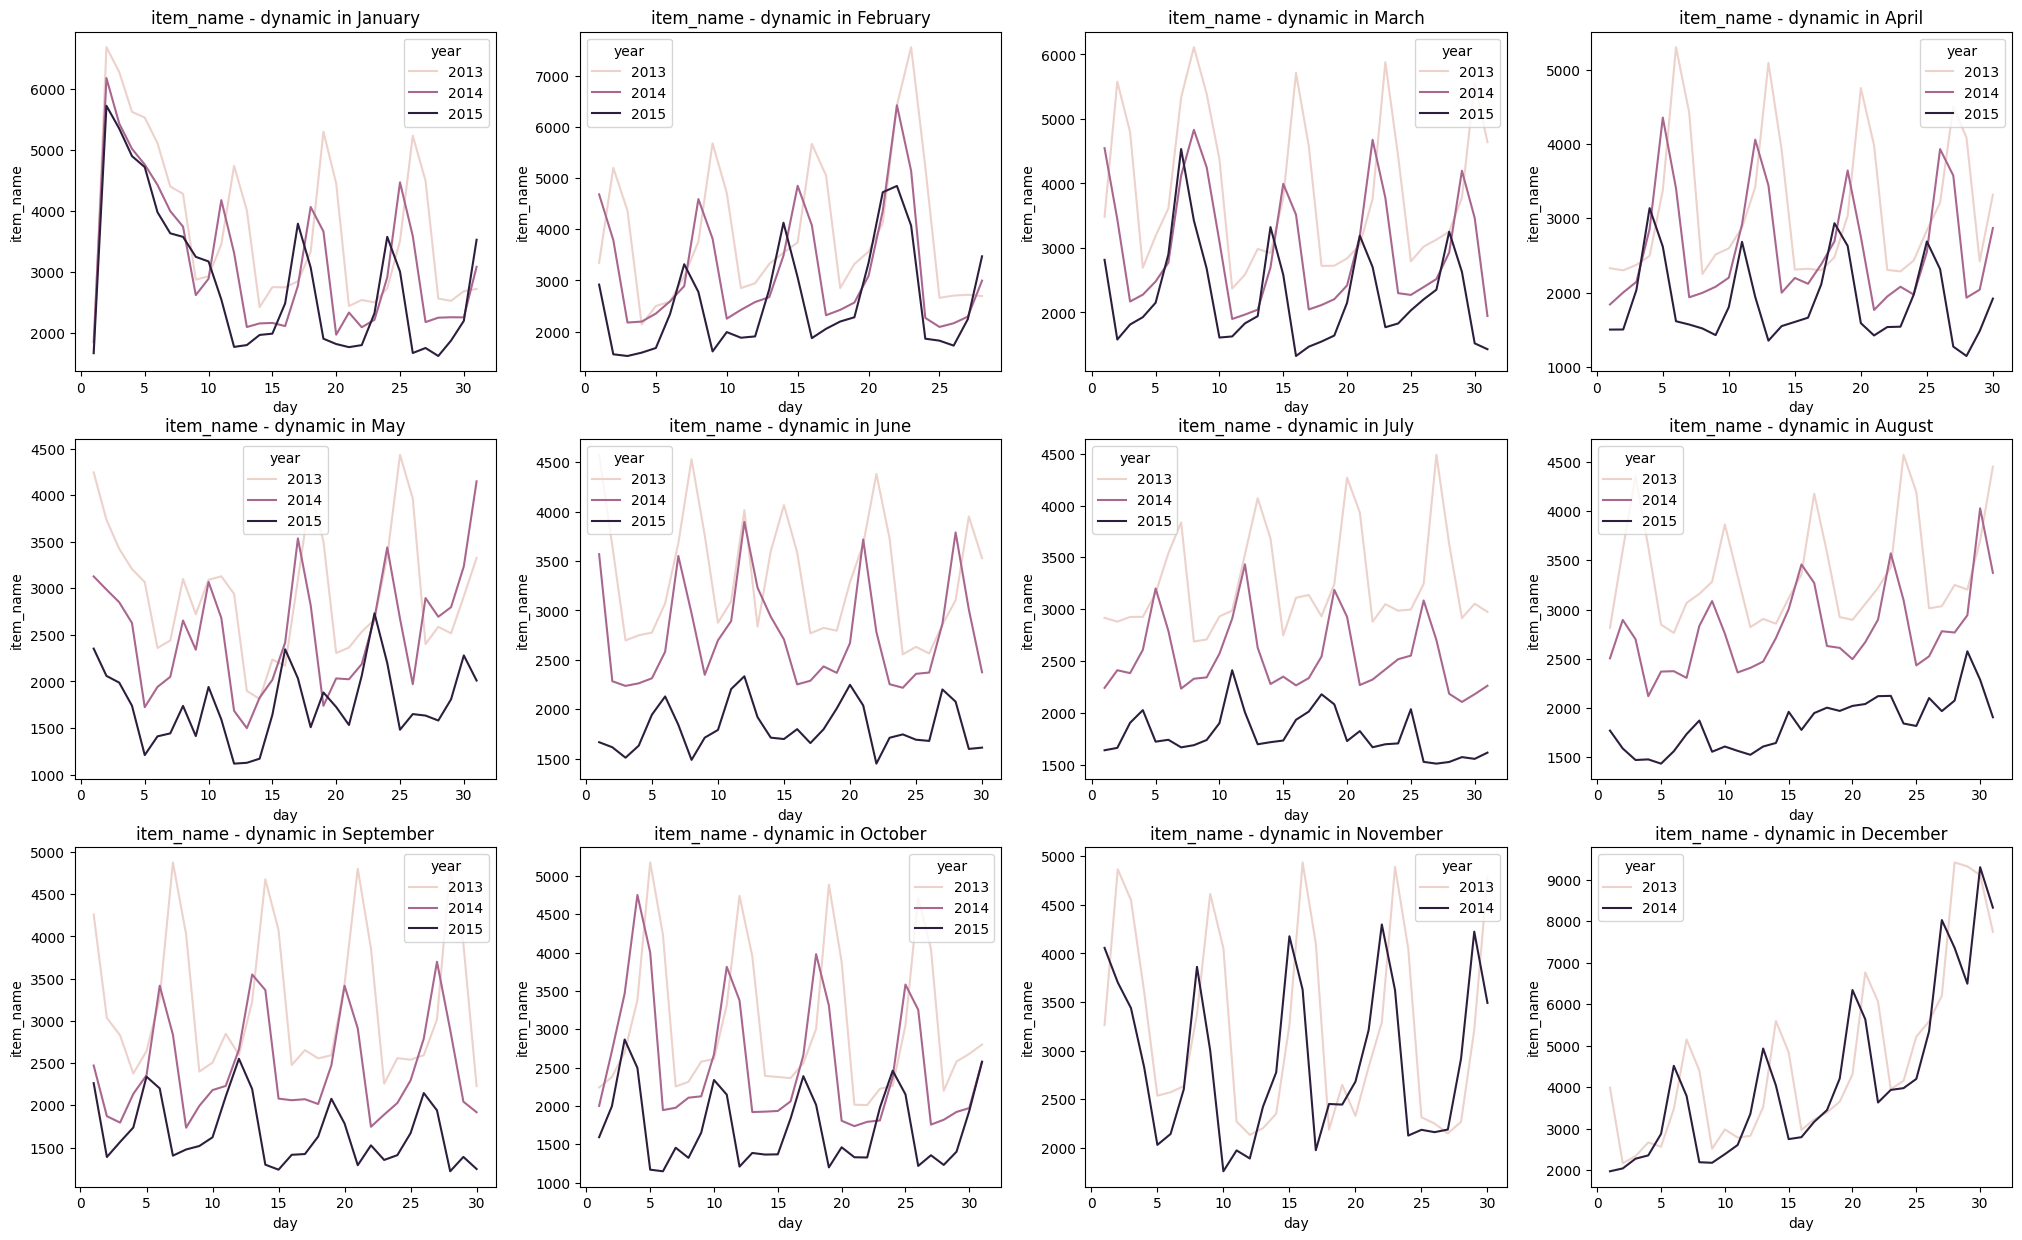

In [48]:
import calendar


p_year_patterns = train.groupby(['day', 'month', 'year']).agg({
    'item_name': 'count',
}).reset_index()

fig, axs = plt.subplots(3, 4, figsize=(25, 15))
    
for month in range(1,13):
    sns.lineplot(data=p_year_patterns[p_year_patterns.month == month], x='day', y='item_name', hue='year', ax=axs[(month - 1) // 4][(month - 1) % 4]).set_title(f"{col} - dynamic in {calendar.month_name[month]}")

C:\Users\jackd\AppData\Local\Temp\ipykernel_10512\2477007135.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = tr.corr(method='spearman')


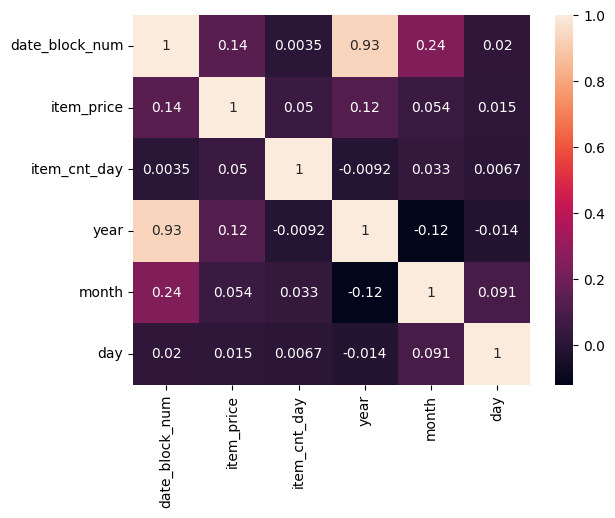

In [49]:
#for numerical feathures
tr = train.copy()
tr.drop(['shop_id','item_id','item_category_id'],inplace=True, axis=1)

corr_matrix = tr.corr(method='spearman')
sns.heatmap(corr_matrix, annot=True);

There is a correlation between the values obtained from the date. Before modeling some of it will be removed.

The biggest correlation target formed with item_price.

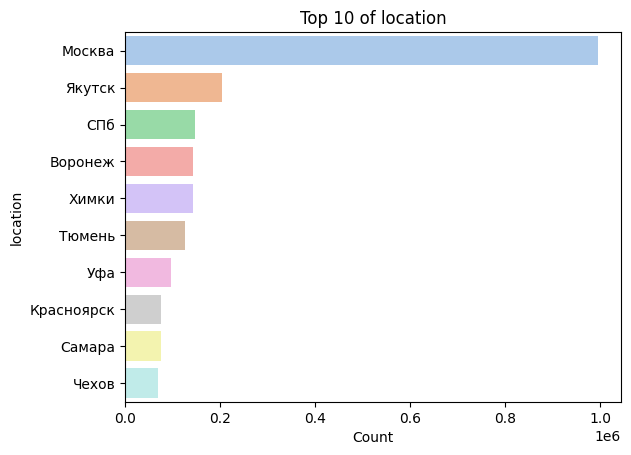

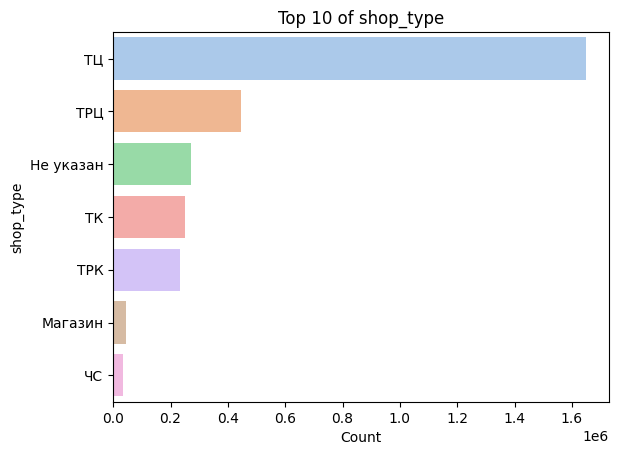

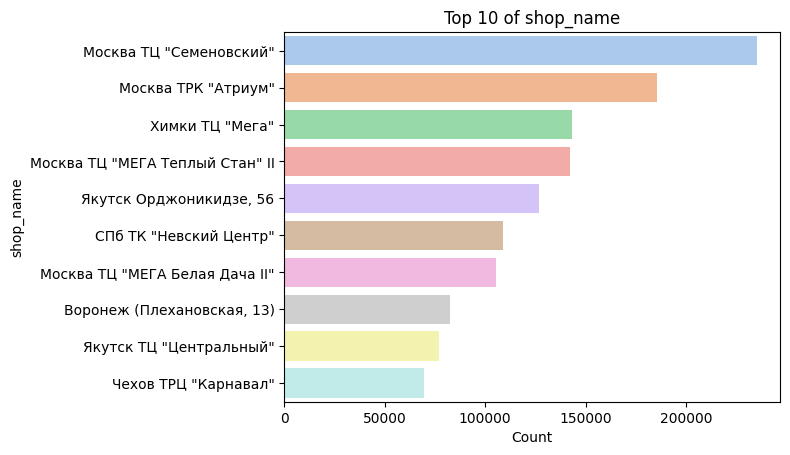

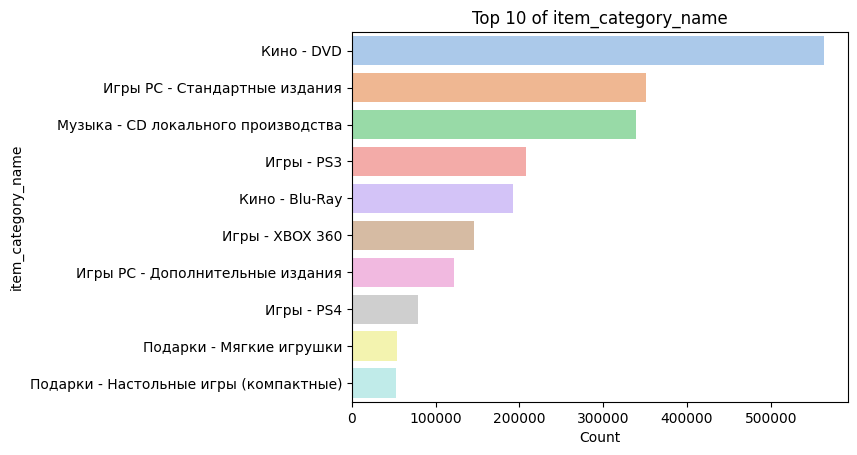

In [50]:
for col in ['location','shop_type','shop_name', 'item_category_name']:
    top_10_locs = train[col].value_counts().head(10)
    top_10_locs = top_10_locs.to_frame().reset_index()
    top_10_locs.columns = [col, 'count']
    sns.barplot(data=top_10_locs, x='count', y=col, palette = 'pastel')
    plt.title(f'Top 10 of {col}')
    plt.ylabel(col)
    plt.xlabel('Count')
    plt.show()

Moscow and it's shops are apperently the most common ones. ТЦ are quite popular.

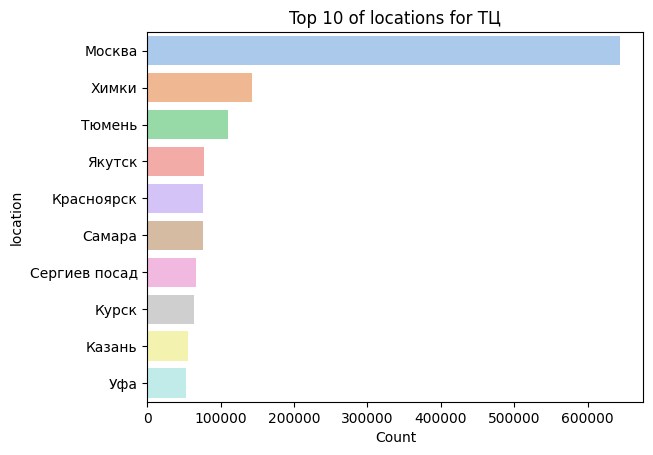

In [51]:
top_10_locs = train[train['shop_type']=='ТЦ']['location'].value_counts().head(10)
top_10_locs = top_10_locs.to_frame().reset_index()
top_10_locs.columns = ['location', 'count']
sns.barplot(data=top_10_locs, x='count', y='location', palette = 'pastel')
plt.title('Top 10 of locations for ТЦ')
plt.ylabel('location')
plt.xlabel('Count')
plt.show()

### What can be done with data

- First of all, we can make data take form that will be more convinient for our main goal. It means that info can be grouped by shops and items, than for every group we can calculate the amount of soled products. Due to the fact that price of an item is not fixed we can try to take mean value.

- In DQC part we extracted shop type and location, maybe these feathures can be useful.

- Shops without all 12 months should be droped.

- As it was stated earlier, seasonality and trend should be looked into.

- While working with time series, it is a common practice to create "lagged" copies of the series. Lagging a time series means to shift its values forward one or more time steps, or equivalently, to shift the times in its index backward one or more steps. We can also do that.

In [53]:
train.to_csv('C:/datasets/sales/train_sls.csv')
test.to_csv('C:/datasets/sales/test_sls.csv')